20 completed...
40 completed...
60 completed...
80 completed...
100 completed...


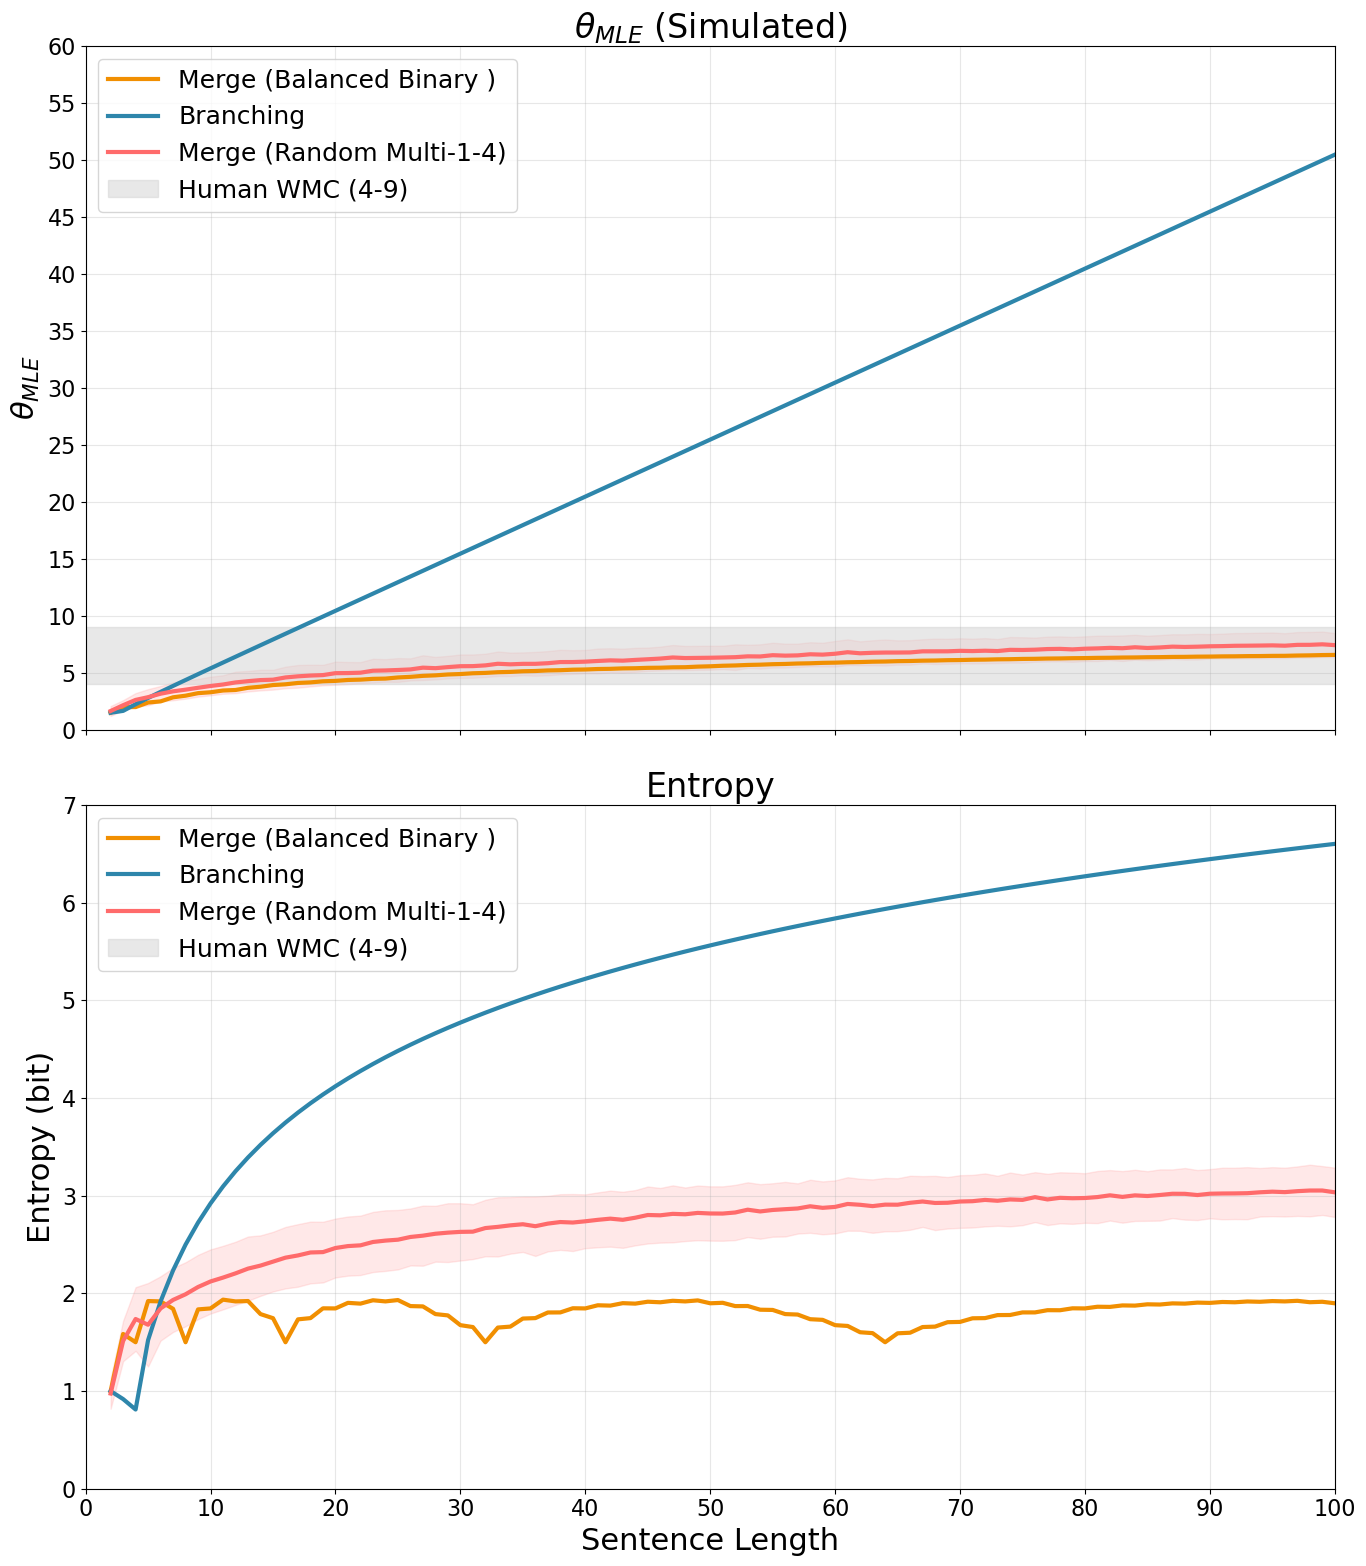

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import random

# -------------------------- 1. Basic Configuration --------------------------
mpl.rcParams.update({'font.size': 18})
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

# -------------------------- 2. Core Functions --------------------------
def calculate_open_nodes(nested_sentence, count_start=1, structure_type="OpenNode"):
    
    def count_total_words(node):
        count = 0
        if isinstance(node, list):
            for item in node:
                count += count_total_words(item)
        elif isinstance(node, str):
            count += 1
        return count
    
    total_words = count_total_words(nested_sentence)
    
    if structure_type == "Flat":
        return [total_words] * total_words
    word_units = []
    word_units_dict = {}
    
    def traverse_sub_component(sub_node, base_offset=0, current_depth=0):
        if isinstance(sub_node, list):
            for idx, item in enumerate(sub_node):
                if idx == 0 and isinstance(item, str):
                    val = base_offset + current_depth + count_start
                    word_units_dict[item] = val
                    word_units.append(val)
                else:
                    traverse_sub_component(item, base_offset, current_depth + 1)
        elif isinstance(sub_node, str):
            val = base_offset + current_depth + count_start
            word_units_dict[sub_node] = val
            word_units.append(val)

    if isinstance(nested_sentence, list):
        for sub_idx, sub_component in enumerate(nested_sentence):
            base_offset = sub_idx
            traverse_sub_component(sub_component, base_offset=base_offset)

    return word_units

def calculate_theta_mean(units):
    return np.sum(units) / len(units) if len(units) > 0 else 0

def calculate_entropy_base2(units):
    if len(units) == 0:
        return 0.0
    unique_vals, counts = np.unique(units, return_counts=True)
    probabilities = counts / len(units)
    entropy = -np.sum([p * np.log2(p) for p in probabilities if p > 0])
    
    return entropy

# -------------------------- 3. Structure Generation Functions --------------------------
def generate_balanced_binary_tree(symbols):
    """Generate balanced binary tree (optimal Merge structure)"""
    if len(symbols) <= 1:
        return symbols[0] if symbols else []
    
    def build_balanced(arr):
        n = len(arr)
        if n == 1:
            return arr[0]
        elif n == 2:
            return [arr[0], arr[1]]
        else:
            mid = n // 2
            left = build_balanced(arr[:mid])
            right = build_balanced(arr[mid:])
            return [left, right]
    
    return build_balanced(symbols)

def generate_strict_left_branching(symbols):
    """[[[[a]b]c]d]"""
    if len(symbols) <= 1:
        return symbols[0] if symbols else []
        
    def build_strict_branch(arr):
        if len(arr) == 1:
            return arr[0]
        return [build_strict_branch(arr[:-1]), arr[-1]]
    
    return build_strict_branch(symbols)

def generate_random_multi_merge(symbols):
    """Generate random merge tree with 1-4 nodes merged each time"""
    if not symbols:
        return []
    if len(symbols) == 1:
        return symbols[0]
    
    nodes = symbols[:]
    while len(nodes) > 1:
        max_merge = min(4, len(nodes))
        merge_count = random.randint(1, max_merge)
        merge_indices = sorted(random.sample(range(len(nodes)), merge_count))
        merged_nodes = [nodes[idx] for idx in merge_indices]
        new_nodes = []
        for idx in range(len(nodes)):
            if idx not in merge_indices:
                new_nodes.append(nodes[idx])
        new_nodes.append(merged_nodes)
        nodes = new_nodes
    return nodes[0]

# -------------------------- 4. Run Experiment --------------------------
sentence_lengths = list(range(2, 101))
sample_num = 1000 

structures = {
    "Merge (Balanced Binary )": generate_balanced_binary_tree,
    "Branching": generate_strict_left_branching,
    "Merge (Random Multi-1-4)": generate_random_multi_merge
}

theta_results = {name: [] for name in structures}
theta_std = {name: [] for name in structures}
entropy_results = {name: [] for name in structures}
entropy_std = {name: [] for name in structures}

for sent_len in sentence_lengths:
    symbols = [f's{i}' for i in range(sent_len)]
    
    for name, generator in structures.items():
        theta_samples = []
        entropy_samples = []
        samples = 1 if "Balanced Binary" in name else sample_num
        
        for _ in range(samples):
            struct = generator(symbols)
            units = calculate_open_nodes(struct, structure_type="OpenNode")
            theta_samples.append(calculate_theta_mean(units))
            entropy_samples.append(calculate_entropy_base2(units))
        
        theta_avg = np.mean(theta_samples)
        theta_std_val = np.std(theta_samples) if len(theta_samples) > 1 else 0
        entropy_avg = np.mean(entropy_samples)
        entropy_std_val = np.std(entropy_samples) if len(entropy_samples) > 1 else 0

        theta_results[name].append(theta_avg)
        theta_std[name].append(theta_std_val)
        entropy_results[name].append(entropy_avg)
        entropy_std[name].append(entropy_std_val)
    
    if sent_len % 20 == 0:
        print(f"{sent_len} completed...")

# -------------------------- 5. Visualization --------------------------
colors = {
    "Merge (Balanced Binary )": "#F18F01",    
    "Branching": "#2E86AB",                   
    "Merge (Random Multi-1-4)": "#FF6B6B"    
}

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 16), sharex=True)

ax1.set_title(r"$\theta_{MLE}$ (Simulated)", fontsize=24)
for name in structures.keys():
    thetas = theta_results[name]
    stds = theta_std[name]
    ax1.plot(sentence_lengths, thetas, 
             label=name, color=colors[name], linewidth=3)
    if name != "Merge (Balanced Binary )":
        ax1.fill_between(sentence_lengths, 
                         np.array(thetas) - np.array(stds),
                         np.array(thetas) + np.array(stds),
                         color=colors[name], alpha=0.15)

ax1.set_ylabel(r"$\theta_{MLE}$", fontsize=22)
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 60)
ax1.set_yticks(np.arange(0, 61, 5))
ax1.tick_params(axis='y', labelsize=16)
ax1.axhspan(4, 9, color='lightgray', alpha=0.5, label='Human WMC (4-9)')
handles, labels = ax1.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax1.legend(by_label.values(), by_label.keys(), fontsize=18, loc='upper left')

ax2.set_title("Entropy", fontsize=24)
for name in structures.keys():
    entropies = entropy_results[name]
    stds = entropy_std[name]
    ax2.plot(sentence_lengths, entropies, 
             label=name, color=colors[name], linewidth=3)
    if name != "Merge (Balanced Binary )":
        ax2.fill_between(sentence_lengths, 
                         np.array(entropies) - np.array(stds),
                         np.array(entropies) + np.array(stds),
                         color=colors[name], alpha=0.15)

ax2.set_xlabel('Sentence Length', fontsize=22)
ax2.set_ylabel('Entropy (bit)', fontsize=22)
ax2.grid(True, alpha=0.3)
ax2.set_xlim(2, 100)
ax2.set_ylim(0, 7)
ax2.set_xticks(np.arange(0, 101, 10))
ax2.tick_params(axis='x', labelsize=16)
ax2.tick_params(axis='y', labelsize=16)
ax2.legend(by_label.values(), by_label.keys(), fontsize=18, loc='upper left')
plt.tight_layout()
plt.savefig('three_operations_theta_entropy_curve.png', dpi=300, bbox_inches='tight')
plt.show()
